In [ ]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

#ljepši prikaz
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.interpolation'] = 'nearest'


In [ ]:
# Putanja do foldera 
DATASET_ROOT = r"C:\Users\Korisnik\Downloads\archive (2)\fruits-360_3-body-problem\fruits-360-3-body-problem"

TRAIN_DIR = os.path.join(DATASET_ROOT, "Training")
TEST_DIR  = os.path.join(DATASET_ROOT, "Test")

print("Train dir exists:", os.path.isdir(TRAIN_DIR))
print("Test dir exists:", os.path.isdir(TEST_DIR))

#Prikaz klasa, postoje samo 3 klase u folderu Fruits 360
train_classes = sorted([d.name for d in Path(TRAIN_DIR).iterdir() if d.is_dir()])
print("\nPrimjer klasa u Train:", train_classes[:3])


Train dir exists: True
Test dir exists: True

Primjer klasa u Train: ['Apple', 'Cherry', 'Tomatoe']


In [ ]:
#učitavanje i prikaz slika u gridu

def load_image_rgb(path, resize_to=None):
    img_bgr = cv2.imread(str(path))
    if img_bgr is None:
        raise ValueError(f"Ne mogu učitati sliku: {path}")
    if resize_to is not None:
        img_bgr = cv2.resize(img_bgr, interpolation=cv2.INTER_AREA)
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def show_images_grid(image_paths, titles=None, cols=4):
    rows = (len(image_paths) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten()

    for ax, p, t in zip(axes, image_paths, (titles or [None]*len(image_paths))):
        img = load_image_rgb(p)
        ax.imshow(img)
        ax.set_title(t if t else Path(p).parent.name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


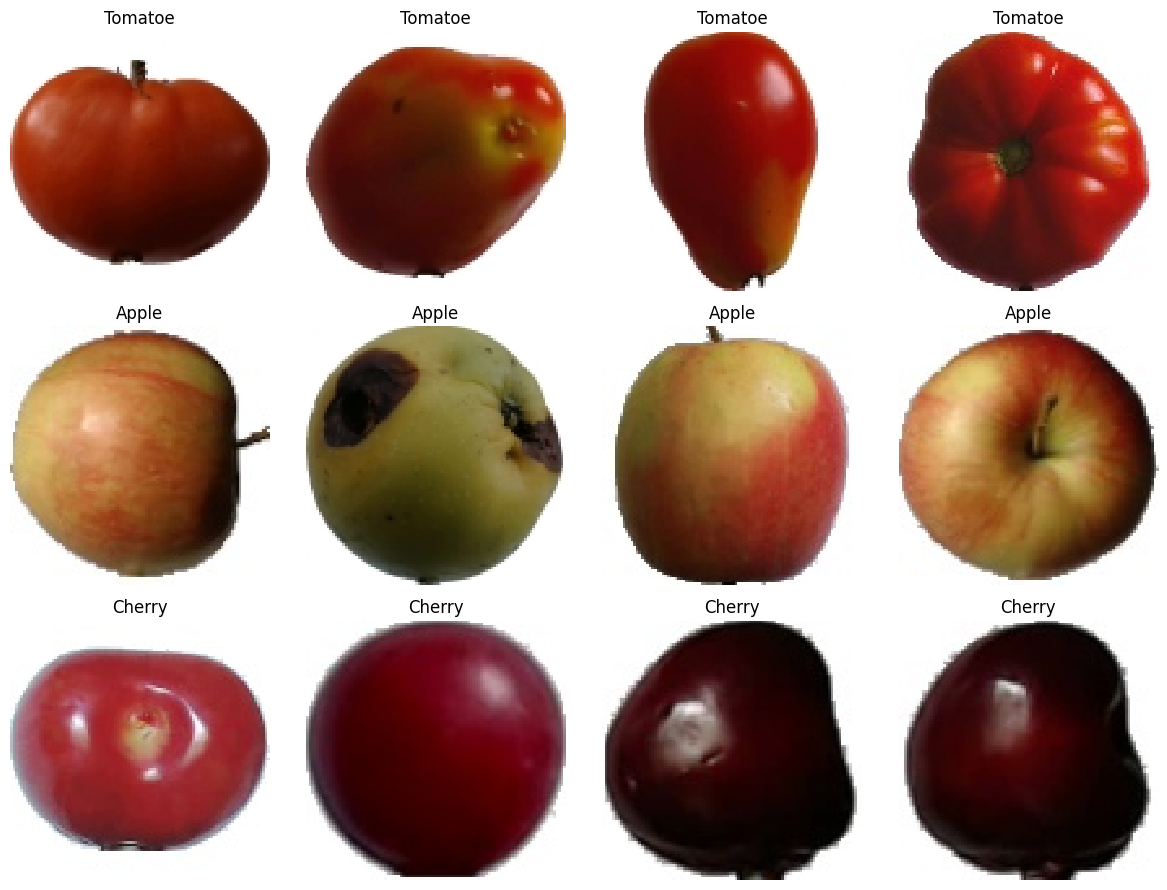

In [74]:
random.seed(42)
n_classes = 3
n_per_class = 4

sample_classes = random.sample(train_classes, n_classes)
all_sample_paths = []
titles = []

for cls in sample_classes:
    cls_dir = Path(TRAIN_DIR) / cls
    imgs = list(cls_dir.rglob("*.jpg")) + list(cls_dir.rglob("*.png"))
    chosen = random.sample(imgs, n_per_class)
    all_sample_paths.extend(chosen)
    titles.extend([cls]*len(chosen))

show_images_grid(all_sample_paths, titles)


Testna slika: C:\Users\Korisnik\Downloads\archive (2)\fruits-360_3-body-problem\fruits-360-3-body-problem\Training\Apple\Apple 13\r1_126_100.jpg


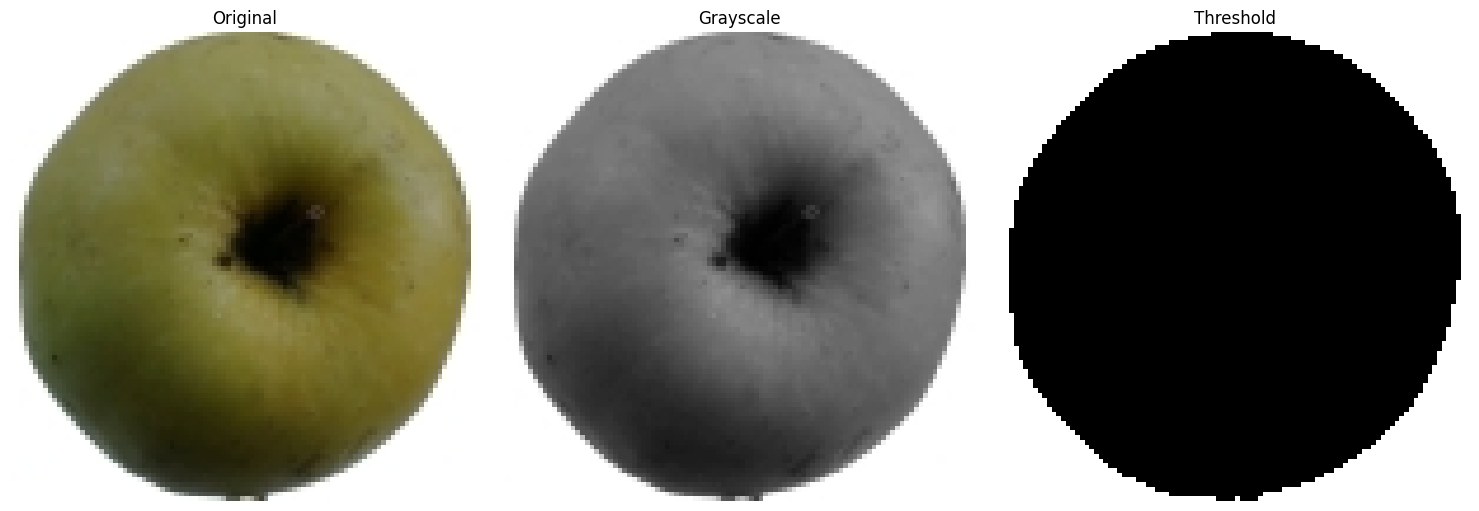

In [ ]:
def show_three_versions(img_path):
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(gray, cmap="gray")
    plt.title("Grayscale")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(thresh, cmap="gray")
    plt.title("Threshold")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return gray, thresh


#Random slika iz klase Apple
apple_dir = Path(TRAIN_DIR) / "Apple"
apple_imgs = list(apple_dir.rglob("*.jpg"))
test_img_path = random.choice(apple_imgs)

print("Testna slika:", test_img_path)
gray, thresh = show_three_versions(test_img_path)


In [ ]:
def extract_hu_moments_from_dir(base_dir):
    """Vrati DataFrame sa Hu momentima, bojama i teksturom."""
    records = []
    base_path = Path(base_dir)
    
    for cls_dir in sorted(base_path.iterdir()):
        if not cls_dir.is_dir():
            continue
        class_name = cls_dir.name
        img_paths = list(cls_dir.rglob("*.jpg")) + list(cls_dir.rglob("*.png"))
        
        for img_path in tqdm(img_paths, desc=f"Processing {class_name}"):
            try:
                img = cv2.imread(str(img_path))
                img = cv2.resize(img, (100,100))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                #Hu momenti
                moments = cv2.moments(gray)
                hu = cv2.HuMoments(moments).flatten()
                hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
                
                #Prosječne boje
                mean_color = cv2.mean(img)[:3]
                
                # Tekstura(varijanca sive slike)
                texture = [np.var(gray)]
                
                features = list(hu) + list(mean_color) + texture
                records.append(features + [class_name])
            except Exception as e:
                print("Greška:", e)
    
    cols = [f"hu{i+1}" for i in range(7)] + ["mean_R", "mean_G", "mean_B", "texture", "label"]
    return pd.DataFrame(records, columns=cols)

print("Ekstrakcija TRAIN značajki...")
train_df = extract_hu_moments_from_dir(TRAIN_DIR)

print("\nEkstrakcija TEST značajki...")
test_df = extract_hu_moments_from_dir(TEST_DIR)

print("\nPrimjer podataka:")
display(train_df.head())


Ekstrakcija TRAIN značajki...


Processing Tomatoe: 100%|██████████| 9995/9995 [00:16<00:00, 595.18it/s]



Ekstrakcija TEST značajki...


Processing Tomatoe: 100%|██████████| 3677/3677 [00:05<00:00, 615.65it/s]


Primjer podataka:


,hu1,hu2,hu3,hu4,hu5,hu6,hu7,mean_R,mean_G,mean_B,texture,label
0,2.844040,8.038645,9.942755,9.648052,-10.0,-9.999971,-10.0,127.2816,138.9745,158.8464,8332.233792,Apple
1,2.848053,8.290163,9.963982,9.698259,10.0,9.999992,-10.0,125.0078,140.5230,156.4726,7128.242985,Apple
2,2.846002,8.255918,9.964434,9.704977,10.0,9.999989,-10.0,125.0917,140.0701,156.7153,7150.185085,Apple
3,2.845076,8.242365,9.959442,9.691519,10.0,9.999989,-10.0,124.3746,139.2836,156.3113,7169.238519,Apple
4,2.842995,8.247416,9.959607,9.688077,10.0,9.999987,-10.0,124.0235,138.5048,156.1149,7175.775311,Apple


In [54]:
from sklearn.preprocessing import LabelEncoder

X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    random_state=42
)

model.fit(X_train, y_train_encoded)

y_pred_encoded = model.predict(X_test)

acc = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"Točnost modela: {acc*100:.2f}%\n")
print("Detaljan izvještaj:")
print(classification_report(y_test_encoded, y_pred_encoded, target_names=label_encoder.classes_))


Točnost modela: 69.54%

Detaljan izvještaj:
              precision    recall  f1-score   support

       Apple       0.65      0.84      0.74      5138
      Cherry       0.68      0.56      0.62      3418
     Tomatoe       0.80      0.61      0.69      3677

    accuracy                           0.70     12233
   macro avg       0.71      0.67      0.68     12233
weighted avg       0.71      0.70      0.69     12233



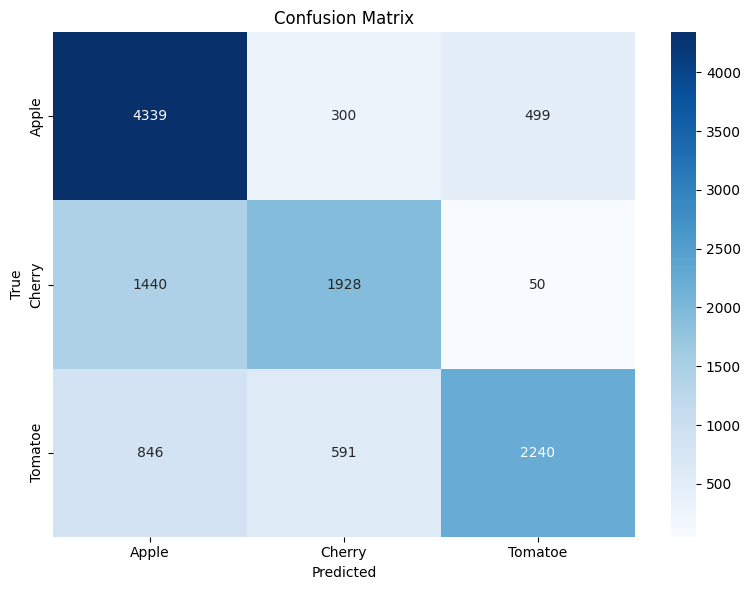

In [ ]:
import seaborn as sns

#konfuzijska matrice
cm = confusion_matrix(y_test_encoded, y_pred_encoded)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()



Iz konfuzijske matrice se vidi da klasu Apple jako dobro prepoznaje tj. najbolja od sve 3 klase, ali je ponekad zamjeni sa druge 2 klase.
Klasa Cherry ima najveći problem jer skoro da podjednako za ovu klasu pretpostavi dobro i zamijeni s klasom Apple.
Klasu Tomatoe dobro prepoznaje, ali ne bolje od klase Apple.

In [63]:
def extract_features_from_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Ne mogu učitati sliku: {image_path}")
    image = cv2.resize(image, (100, 100))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Hu momenti
    moments = cv2.moments(gray)
    hu = cv2.HuMoments(moments).flatten()
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
    
    # Boje i tekstura
    mean_color = cv2.mean(image)[:3]
    texture = [np.var(gray)]
    
    return np.hstack([hu, mean_color, texture])

# Testna slika
sample_image = r"C:\Users\Korisnik\Downloads\pome-fruit-apple-detail-1.jpeg"
#sample_image = r"C:\Users\Korisnik\Downloads\garden-guide_tomato_main-image.jpg"

sample_features = extract_features_from_image(sample_image).reshape(1, -1)

pred_label_encoded = model.predict(sample_features)[0]
pred_class = label_encoder.inverse_transform([pred_label_encoded])[0]

print("Predviđena klasa:", pred_class)


Predviđena klasa: Apple


c:\Users\Korisnik\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


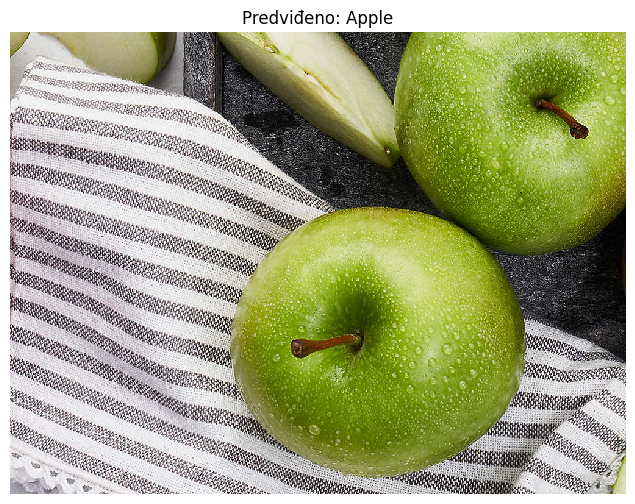

In [64]:
img = cv2.imread(sample_image)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Predviđeno: {pred_class}")
plt.show()
